In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt

In [3]:
import os
import pickle
import numpy as np
from scipy import sparse
from functools import partial
from sklearn.externals import joblib
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [4]:
labels = joblib.load("/home/jovyan/persistent_data/data/dumps/labeled_corpus_labels.pkl")
features = joblib.load("/home/jovyan/persistent_data/data/dumps/labeled_corpus_matrix.pkl")
features = features.todense()
mozart_labels = [k for k in range(len(labels)) if labels[k] == "mozart"]
bach_labels = [k for k in range(len(labels)) if labels[k] == "bach-js"]
schubert_labels = [k for k in range(len(labels)) if labels[k] == "schubert"]
chopin_labels = [k for k in range(len(labels)) if labels[k] == "chopin"]
tchaikovsky_labels = [k for k in range(len(labels)) if labels[k] == "tchaikovsky"]
X = features[mozart_labels + bach_labels + schubert_labels + chopin_labels + tchaikovsky_labels].A
y = np.array([0 for i in range(len(mozart_labels))] + [1 for i in range(len(bach_labels))] + 
            [2 for i in range(len(schubert_labels))] + [3 for i in range(len(chopin_labels))] +
            [4 for i in range(len(tchaikovsky_labels))])
y = y.reshape((y.shape[0],))
del features

In [5]:
X = X[:,X.sum(axis=0).nonzero()[0]]

In [6]:
import pywFM

In [7]:
# %%bash
# git clone https://github.com/srendle/libfm ./libfm
# cd ./libfm/ && make all
# export LIBFM_PATH=/home/jovyan/persistent_data/midi-ml/notebooks/ProjectTwoResults/libfm/bin/

In [8]:
# %%bash
# export LIBFM_PATH=/home/jovyan/persistent_data/midi-ml/notebooks/ProjectTwoResults/libfm/bin/

In [9]:
# %%bash
# pip install pywFM

In [10]:
import os
os.environ["LIBFM_PATH"] = "/home/jovyan/persistent_data/midi-ml/notebooks/ProjectTwoResults/libfm/bin/"

In [11]:
# X = sparse.dok_matrix(X.astype(np.float64)).A

In [ ]:
predicted = []
actuals = []
fm_models = []
i = 0
for train_idx, test_idx in KFold(n=X.shape[0], n_folds=10, shuffle=True):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    fm = pywFM.FM(task="classification", learning_method="mcmc",
                 k0=True, k1=True,
                  verbose=True,
                 num_iter=10000)
    try:
        classes = np.unique(y)
        models = []
        for cls in classes:
            y_train_cls = np.array([1 if y_i == cls else 0 for y_i in y_train])
            y_test_cls = np.array([1 if y_i == cls else 0 for y_i in y_test])
            print(cls)
            model = fm.run(X_train, y_train_cls, X_test, y_test_cls)
            models.append(model)
    except:
        continue
    
    preds = [m.predictions for m in models]
    predicted.append(preds)
    actuals.append(y_test)
#     fm_models.append(models.)
#     pickle.dump(models, open("./dumps/factorization_machine/model_fold_{fold}.pkl"
#                                 .format(fold=str(i)), 'wb'))
    pickle.dump(predicted, open("./dumps/factorization_machine/predicted_fold_{fold}.pkl"
                                .format(fold=str(i)), 'wb'))
    pickle.dump(actuals, open("./dumps/factorization_machine/actuals_fold_{fold}.pkl"
                                .format(fold=str(i)), 'wb'))
    i += 1

0


In [ ]:
print(1)

In [164]:
# preds = (np.array(model.predictions) > (1-y.sum() / y.shape[0])).astype(int)
preds = (np.array(model.predictions) > 0.9).astype(int)

In [14]:
print(1)

1


In [166]:
from sklearn import metrics

In [167]:
print(metrics.accuracy_score(y_test, preds))
print(metrics.confusion_matrix(y_test, preds))

0.785714285714
[[519 105]
 [ 57  75]]


In [16]:
os.listdir(model_folder)

['predicted_fold_9.pkl',
 'predicted_fold_0.pkl',
 'actuals_fold_5.pkl',
 'predicted_fold_5.pkl',
 'actuals_fold_2.pkl',
 'predicted_fold_1.pkl',
 'predicted_fold_7.pkl',
 'actuals_fold_4.pkl',
 'actuals_fold_6.pkl',
 'predicted_fold_3.pkl',
 'predicted_fold_4.pkl',
 'predicted_fold_2.pkl',
 'actuals_fold_0.pkl',
 'model_fold_0.pkl',
 'actuals_fold_8.pkl',
 'actuals_fold_9.pkl',
 'predicted_fold_6.pkl',
 'actuals_fold_7.pkl',
 'actuals_fold_3.pkl',
 'predicted_fold_8.pkl',
 'actuals_fold_1.pkl']

In [28]:
from sklearn import metrics


# Results

In [44]:
import seaborn as sns
from scipy.stats.distributions import beta
def posterior_overlap_eval(actual, pred, labels, granularity=10000):
    colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')
    tp_fn = []
    confusion = metrics.confusion_matrix(actual, pred)
    for i in range(confusion.shape[0]):
        tp = confusion[i,i]
        fn = np.delete(confusion[i,:], i).sum()
        tp_fn.append((tp, fn))
    betas = [beta(a=1 + tp, b = 1 + fn) for tp, fn in tp_fn]
    for i, beta_dist in enumerate(betas):
        random_draws = beta_dist.rvs(granularity)
        plt.hist(random_draws, alpha=0.2, color=colors[i], bins=np.linspace(0,1, 100))
        plt.vlines(random_draws.mean(), 0, 2000, label=labels[i], color=colors[i], linestyles="dotted")
    plt.legend(loc="upper left")
    plt.show()
labs = ["mozart", "bach", "schubert", "chopin", "tchaikovsky"]

In [58]:
model_folder = "/home/jovyan/persistent_data/midi-ml/notebooks/ProjectTwoResults/dumps/factorization_machine/"
accuracy = []
precision = []
recall = []
f1 = []
mcc = []
predicted = pickle.load(open(model_folder + "predicted_fold_3.pkl", 'rb'))
actuals = pickle.load(open(model_folder + "actuals_fold_3.pkl", 'rb'))
for preds, actual in zip(predicted, actuals):
    pred = np.array(preds).argmax(axis=0)
    print("confusion matrix")
    print(metrics.confusion_matrix(actual, pred))
    print("\taccuracy")
    acc = metrics.accuracy_score(actual, pred)
    accuracy.append(acc)
    print("\t\t", acc)
    print("\tf1")
    f = metrics.f1_score(actual, pred)
    f1.append(f)
    print("\t\t", f)
    print("\trecall")
    r = metrics.recall_score(actual, pred)
    recall.append(r)
    print("\t\t", r)
    print("\tprecision")
    p = metrics.precision_score(actual, pred)
    precision.append(p)
    print("\t\t", p)
#     posterior_overlap_eval(actual, pred, labels=labs)

confusion matrix
[[ 26  36   5   4   3]
 [ 10 200   9   5   4]
 [  6   6  10   2   2]
 [  5   4   1  12   2]
 [  4  10   7   2   3]]
	accuracy
		 0.664021164021
	f1
		 0.645064474466
	recall
		 0.664021164021
	precision
		 0.637743171343
confusion matrix
[[ 31  21   8   1   4]
 [ 21 189   6   3   8]
 [ 10  10  10   2   5]
 [  6   6   3   4   4]
 [  5  10   5   2   4]]
	accuracy
		 0.62962962963
	f1
		 0.62060646659
	recall
		 0.62962962963
	precision
		 0.615831426651
confusion matrix
[[ 26  29   4   3   4]
 [ 16 204   3   5   3]
 [  6   9   5   2   5]
 [  5  15   2   7   3]
 [  3  10   1   3   5]]
	accuracy
		 0.653439153439
	f1
		 0.628746589606
	recall
		 0.653439153439
	precision
		 0.615971532183
confusion matrix
[[ 39  17   3   3   3]
 [ 23 213   4   4   2]
 [ 10   3   6   1   2]
 [  3   9   5  11   0]
 [  7   3   3   0   4]]
	accuracy
		 0.722222222222
	f1
		 0.719647262413
	recall
		 0.722222222222
	precision
		 0.723444657896


/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample

In [56]:
np.max(accuracy)

0.72222222222222221

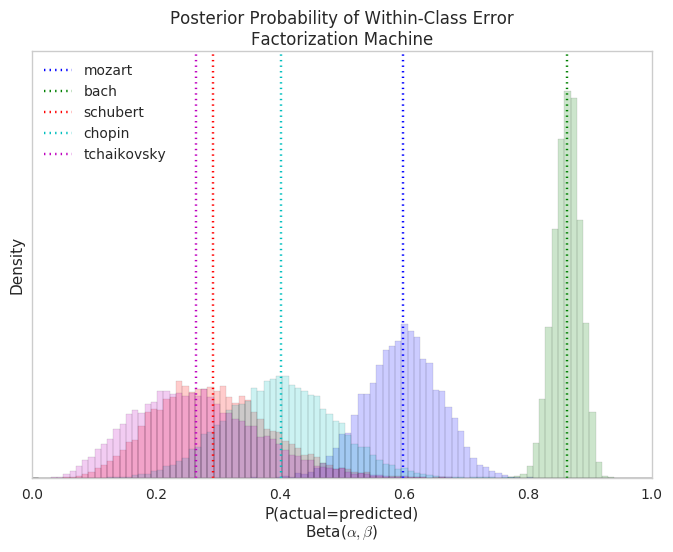

In [59]:
mymodel = "Factorization Machine"
sns.set_style("whitegrid")
plt.title("Posterior Probability of Within-Class Error\n{model}".format(model=mymodel))
plt.xlabel('P(actual=predicted)\n' + r'Beta($\alpha, \beta$)')
plt.ylabel("Density")
plt.yticks([])
ax = plt.gca()
ax.grid(False)
posterior_overlap_eval(actual, pred, labels=labs)

In [52]:
metrics.confusion_matrix(actual, pred)

array([[ 39,  17,   3,   3,   3],
       [ 23, 213,   4,   4,   2],
       [ 10,   3,   6,   1,   2],
       [  3,   9,   5,  11,   0],
       [  7,   3,   3,   0,   4]])